In [2]:
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

/home/linu/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


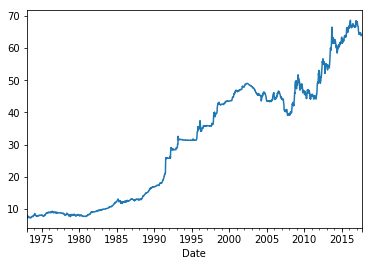

In [5]:
names=["Date","Value"]
series = read_csv('INR-vs-USD.csv',index_col=0,names=names,header=0)
series.index = pd.to_datetime(series.index)
resampled_series = series['Value'].resample('W').mean() #Resample with Month Start frequency
resampled_series.plot()

In [46]:
train_size=int(len(resampled_series)*5/10)
print(train_size)
test_size=len(resampled_series)-train_size
print(test_size)

1165
1165


In [47]:
train_data=resampled_series[:train_size]
test_data=resampled_series[train_size:]

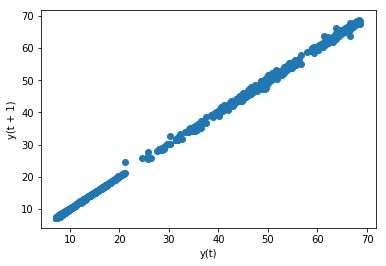

In [48]:
lag_plot(resampled_series)

In [49]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(resampled_series)

Results of Dickey-Fuller Test:
Test Statistic                    0.018332
p-value                           0.960022
#Lags Used                       27.000000
Number of Observations Used    2302.000000
Critical Value (1%)              -3.433194
Critical Value (5%)              -2.862796
Critical Value (10%)             -2.567439
dtype: float64


In [50]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(resampled_series)


Results of KPSS Test:
Test Statistic            8.038926
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/linu/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


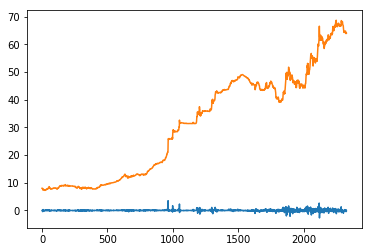

In [51]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

diff=difference(resampled_series)
diff.plot()

def inverse_difference(last_ob, value):
	return value + last_ob

inverted = [inverse_difference(resampled_series[i], diff[i]) for i in range(len(diff))]
inverted=pd.Series(inverted)
inverted.plot()

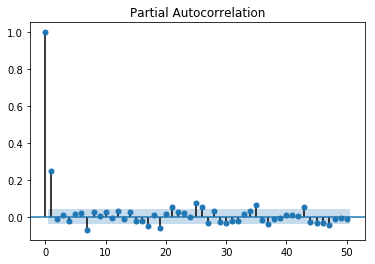

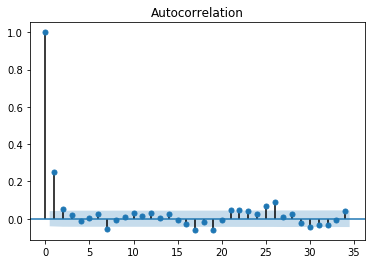

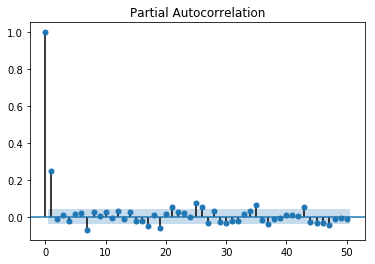

In [52]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(diff)
plot_pacf(diff, lags=50)

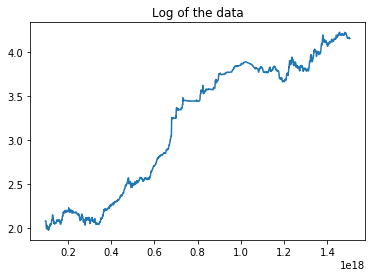

In [53]:
import numpy as np
ts_log = np.log(resampled_series)
plt.title('Log of the data')
plt.plot(ts_log)
plt.show()

In [54]:
import statsmodels.api as sm
# walk-forward validation
history = [x for x in train_data]
predictions = list()

def StartARIMAForecasting(Actual, P, D, Q):
    model = sm.tsa.statespace.SARIMAX(Actual,
                                order=(2, 1, 2),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)             

    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction
    """
    model = ARIMA(Actual, order=(2, 2, 2))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction"""


for i in range(len(test_data)):
	# predict
	yhat = StartARIMAForecasting(history,2,1,2)
	predictions.append(yhat)
	# observation
	obs = test_data[i]
	history.append(obs)
	print('>Predicted=%f, Expected=%f' % (yhat, obs))


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.400782, Expected=31.428400


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.434387, Expected=31.409000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.409522, Expected=31.440000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.447485, Expected=31.400800


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.411372, Expected=31.415625


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.415638, Expected=31.408400


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.409036, Expected=31.404000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.406221, Expected=31.392000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.390325, Expected=31.399800


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.402298, Expected=31.390000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.391188, Expected=31.377200


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.377519, Expected=31.380000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.383481, Expected=31.385800


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.386726, Expected=31.421400


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.426184, Expected=31.453400


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.456590, Expected=31.558000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.568957, Expected=31.698000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.711274, Expected=31.865000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=31.882024, Expected=32.290000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=32.332810, Expected=33.204000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=33.344823, Expected=33.866000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.030923, Expected=33.952000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.068868, Expected=33.892000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=33.976224, Expected=34.018750


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.100949, Expected=35.020000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.221571, Expected=35.590000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.770672, Expected=34.600000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.523709, Expected=34.564000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.605497, Expected=34.652000
>Predicted=34.704469, Expected=34.837500
>Predicted=34.910958, Expected=34.922000
>Predicted=34.998563, Expected=34.880000
>Predicted=34.930021, Expected=34.925000
>Predicted=34.969674, Expected=34.994000
>Predicted=35.038020, Expected=35.100000
>Predicted=35.154588, Expected=35.297500


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.389212, Expected=35.822000
>Predicted=35.947801, Expected=35.893750
>Predicted=35.898281, Expected=35.916000
>Predicted=35.966621, Expected=36.400000
>Predicted=36.514400, Expected=37.450000
>Predicted=37.656385, Expected=36.666000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=36.626225, Expected=36.567500
>Predicted=36.651446, Expected=35.246000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.132713, Expected=34.284000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.083319, Expected=34.244000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.154056, Expected=35.130000
>Predicted=35.299051, Expected=34.260000
>Predicted=34.202031, Expected=34.300000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.325042, Expected=34.220000
>Predicted=34.235399, Expected=34.340000
>Predicted=34.399134, Expected=34.290000
>Predicted=34.353383, Expected=34.696000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.713492, Expected=34.870000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=34.918176, Expected=35.080000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.066216, Expected=35.140000
>Predicted=35.138844, Expected=35.225000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.271973, Expected=35.052000
>Predicted=35.105857, Expected=35.060000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.042062, Expected=35.100000
>Predicted=35.138980, Expected=35.186000
>Predicted=35.222588, Expected=35.150000
>Predicted=35.181476, Expected=35.500000
>Predicted=35.568956, Expected=35.856000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.956118, Expected=35.790000
>Predicted=35.828270, Expected=35.910000
>Predicted=35.968657, Expected=35.850000
>Predicted=35.883327, Expected=35.800000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.831697, Expected=35.780000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.801958, Expected=35.850000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.890946, Expected=35.875000
>Predicted=35.915499, Expected=35.870000
>Predicted=35.905787, Expected=35.890000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.922788, Expected=35.850000
>Predicted=35.892382, Expected=35.830000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.871922, Expected=35.820000
>Predicted=35.843179, Expected=35.757500
>Predicted=35.784064, Expected=35.770000
>Predicted=35.795968, Expected=35.848000
>Predicted=35.884088, Expected=35.862000
>Predicted=35.892279, Expected=35.937500
>Predicted=35.979150, Expected=35.761400
>Predicted=35.769363, Expected=35.809250
>Predicted=35.839801, Expected=35.830000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.860203, Expected=35.906400
>Predicted=35.940929, Expected=35.900000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.925506, Expected=35.857500
>Predicted=35.877743, Expected=35.962500
>Predicted=35.998616, Expected=35.929400
>Predicted=35.953242, Expected=35.890000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.914079, Expected=35.875000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.898042, Expected=35.886000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.914849, Expected=35.882000
>Predicted=35.897754, Expected=35.892000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.919975, Expected=35.895000
>Predicted=35.919764, Expected=35.894000
>Predicted=35.920292, Expected=35.877000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.897207, Expected=35.866000
>Predicted=35.885167, Expected=35.898000
>Predicted=35.928597, Expected=35.899000
>Predicted=35.919542, Expected=35.884000
>Predicted=35.902279, Expected=35.872000
>Predicted=35.891026, Expected=35.823400
>Predicted=35.838581, Expected=35.776400
>Predicted=35.789800, Expected=35.770000
>Predicted=35.788765, Expected=35.856200
>Predicted=35.885706, Expected=35.851000
>Predicted=35.870536, Expected=35.795000
>Predicted=35.806335, Expected=35.820000
>Predicted=35.840626, Expected=35.800400
>Predicted=35.817925, Expected=35.821400
>Predicted=35.841384, Expected=35.823000
>Predicted=35.840562, Expected=35.830000
>Predicted=35.848075, Expected=35.817500
>Predicted=35.831418, Expected=35.780000
>Predicted=35.790467, Expected=35.728000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.736147, Expected=35.711000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.727744, Expected=35.745400
>Predicted=35.764069, Expected=35.747800
>Predicted=35.761282, Expected=35.747800


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=35.764352, Expected=36.074000
>Predicted=36.128696, Expected=36.506000
>Predicted=36.582706, Expected=36.640000
>Predicted=36.683291, Expected=36.588000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=36.606028, Expected=36.494000
>Predicted=36.503688, Expected=36.320000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=36.316966, Expected=36.373400
>Predicted=36.396505, Expected=36.234000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=36.235745, Expected=36.257250
>Predicted=36.278729, Expected=36.260000
>Predicted=36.278475, Expected=36.339000
>Predicted=36.367021, Expected=36.451000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=36.498109, Expected=36.750000
>Predicted=36.826393, Expected=37.502000
>Predicted=37.631040, Expected=38.608750


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=38.813955, Expected=39.310000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=39.495744, Expected=39.299000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=39.333927, Expected=39.915000
>Predicted=40.099332, Expected=39.092500
>Predicted=39.016734, Expected=39.302500
>Predicted=39.337395, Expected=39.708000
>Predicted=39.780376, Expected=40.134000
>Predicted=40.208107, Expected=38.962500


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=38.859491, Expected=38.672000
>Predicted=38.606302, Expected=38.880000
>Predicted=38.923530, Expected=38.790000
>Predicted=38.817997, Expected=39.035000
>Predicted=39.091062, Expected=39.332000
>Predicted=39.314726, Expected=39.552000
>Predicted=39.640817, Expected=39.577000
>Predicted=39.516291, Expected=39.601000
>Predicted=39.629922, Expected=39.556000
>Predicted=39.570063, Expected=39.548000
>Predicted=39.568104, Expected=39.685800
>Predicted=39.630396, Expected=39.708000
>Predicted=39.708651, Expected=39.752000
>Predicted=39.771625, Expected=39.779000
>Predicted=39.776574, Expected=39.799000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=39.811961, Expected=40.158000
>Predicted=40.225940, Expected=40.583600
>Predicted=40.672910, Expected=41.712500
>Predicted=41.899401, Expected=41.864000
>Predicted=41.954171, Expected=42.282000
>Predicted=42.357157, Expected=42.380000
>Predicted=42.443842, Expected=42.870000
>Predicted=42.957716, Expected=42.558000
>Predicted=42.578021, Expected=42.652000
>Predicted=42.634921, Expected=42.680000
>Predicted=42.711445, Expected=42.538400
>Predicted=42.505131, Expected=42.604000
>Predicted=42.638706, Expected=42.606000
>Predicted=42.621256, Expected=43.016000
>Predicted=43.145881, Expected=43.176000
>Predicted=43.222829, Expected=42.612000
>Predicted=42.574828, Expected=42.627000
>Predicted=42.592863, Expected=42.592500
>Predicted=42.617169, Expected=42.567000
>Predicted=42.523144, Expected=42.576000
>Predicted=42.585423, Expected=42.508000
>Predicted=42.495053, Expected=42.430000
>Predicted=42.407504, Expected=42.357500
>Predicted=42.343564, Expected=42.340000
>Predicted=42.33

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.654428, Expected=43.638000
>Predicted=43.634807, Expected=43.634000
>Predicted=43.630636, Expected=43.634000
>Predicted=43.635214, Expected=43.644000
>Predicted=43.645884, Expected=43.656400
>Predicted=43.661036, Expected=43.698000
>Predicted=43.705516, Expected=43.693400
>Predicted=43.697299, Expected=43.691000
>Predicted=43.689278, Expected=43.704000
>Predicted=43.709842, Expected=44.058000
>Predicted=44.104353, Expected=44.108000
>Predicted=44.141884, Expected=44.204000
>Predicted=44.222386, Expected=44.662500
>Predicted=44.739888, Expected=44.806000
>Predicted=44.861670, Expected=44.800000
>Predicted=44.821625, Expected=44.750000
>Predicted=44.752178, Expected=44.720000
>Predicted=44.717476, Expected=44.750000
>Predicted=44.751802, Expected=44.762000
>Predicted=44.764590, Expected=44.848000
>Predicted=44.861731, Expected=44.922000
>Predicted=44.961278, Expected=45.300000
>Predicted=45.358347, Expected=45.784000
>Predicted=45.887155, Expected=45.860000
>Predicted=45.94

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.853548, Expected=46.872000
>Predicted=46.881904, Expected=46.850000
>Predicted=46.853452, Expected=46.994000
>Predicted=47.007723, Expected=47.024000
>Predicted=47.036844, Expected=47.017500
>Predicted=47.026390, Expected=47.024000
>Predicted=47.032571, Expected=47.052000
>Predicted=47.052479, Expected=47.028000
>Predicted=47.024043, Expected=47.064000
>Predicted=47.073790, Expected=47.175000
>Predicted=47.208997, Expected=47.200000
>Predicted=47.201803, Expected=47.162000
>Predicted=47.163651, Expected=47.172000
>Predicted=47.169670, Expected=47.162000
>Predicted=47.171480, Expected=47.162000
>Predicted=47.161516, Expected=47.162000
>Predicted=47.161498, Expected=47.176000
>Predicted=47.176847, Expected=47.178000
>Predicted=47.181264, Expected=47.227500
>Predicted=47.232289, Expected=47.502500
>Predicted=47.546653, Expected=47.978000
>Predicted=48.071219, Expected=48.142000
>Predicted=48.205582, Expected=48.022000
>Predicted=48.024847, Expected=48.105000
>Predicted=48.11

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=48.685159, Expected=48.624000
>Predicted=48.610576, Expected=48.572000
>Predicted=48.561749, Expected=48.548000
>Predicted=48.536026, Expected=48.512500
>Predicted=48.501681, Expected=48.494000
>Predicted=48.482753, Expected=48.442000
>Predicted=48.431023, Expected=48.424000
>Predicted=48.414505, Expected=48.388000
>Predicted=48.381292, Expected=48.364000
>Predicted=48.350395, Expected=48.407500
>Predicted=48.412341, Expected=48.390000
>Predicted=48.388350, Expected=48.392000
>Predicted=48.387597, Expected=48.340000
>Predicted=48.330556, Expected=48.280000
>Predicted=48.266516, Expected=48.228000
>Predicted=48.214393, Expected=48.275000
>Predicted=48.275319, Expected=48.268000
>Predicted=48.266752, Expected=48.216000
>Predicted=48.206945, Expected=48.126000
>Predicted=48.108856, Expected=48.032500
>Predicted=48.010061, Expected=48.010000
>Predicted=48.002267, Expected=47.994000
>Predicted=47.985575, Expected=47.960000
>Predicted=47.952796, Expected=47.930000
>Predicted=47.91

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=47.343918, Expected=47.358000
>Predicted=47.359128, Expected=47.262000
>Predicted=47.238607, Expected=47.146000
>Predicted=47.124259, Expected=46.924000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.887116, Expected=46.987500
>Predicted=46.970140, Expected=46.934000
>Predicted=46.929812, Expected=46.758000
>Predicted=46.720832, Expected=46.610000
>Predicted=46.566459, Expected=46.556000
>Predicted=46.532169, Expected=46.412500
>Predicted=46.382023, Expected=46.238000
>Predicted=46.197881, Expected=46.188000
>Predicted=46.165360, Expected=46.176000
>Predicted=46.157305, Expected=46.152000
>Predicted=46.138245, Expected=46.066000
>Predicted=46.036912, Expected=45.966000
>Predicted=45.951016, Expected=45.862000
>Predicted=45.835039, Expected=45.884000
>Predicted=45.864694, Expected=45.865000
>Predicted=45.853107, Expected=45.798000
>Predicted=45.784593, Expected=45.926000
>Predicted=45.930522, Expected=45.814000
>Predicted=45.797128, Expected=45.618000
>Predicted=45.582622, Expected=45.392000
>Predicted=45.346658, Expected=45.505000
>Predicted=45.496698, Expected=45.338000
>Predicted=45.312969, Expected=45.350000
>Predicted=45.329713, Expected=45.320000
>Predicted=45.31

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.301167, Expected=45.236000
>Predicted=45.233917, Expected=45.257500
>Predicted=45.236857, Expected=45.296000
>Predicted=45.293314, Expected=45.286000
>Predicted=45.286426, Expected=45.248000
>Predicted=45.243831, Expected=45.238000
>Predicted=45.241352, Expected=44.793000
>Predicted=44.725340, Expected=43.724000
>Predicted=43.520752, Expected=43.594000
>Predicted=43.494241, Expected=43.790000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.786532, Expected=44.018000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=44.034256, Expected=44.292000
>Predicted=44.347886, Expected=44.688000
>Predicted=44.763286, Expected=45.294000
>Predicted=45.424481, Expected=45.342000
>Predicted=45.381334, Expected=45.378000
>Predicted=45.384976, Expected=45.272500
>Predicted=45.261230, Expected=45.046000
>Predicted=44.970764, Expected=45.444000
>Predicted=45.440041, Expected=45.898000
>Predicted=45.999423, Expected=45.932000
>Predicted=45.968406, Expected=45.825000
>Predicted=45.817313, Expected=45.914000
>Predicted=45.937398, Expected=46.198000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.260994, Expected=46.336000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.389284, Expected=46.348000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.354437, Expected=46.308000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.306588, Expected=46.312000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.310865, Expected=46.309000
>Predicted=46.303238, Expected=46.338000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.353052, Expected=46.315000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.333372, Expected=45.900000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.833506, Expected=45.884000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.875665, Expected=45.966000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.979404, Expected=45.846000
>Predicted=45.838184, Expected=45.840000
>Predicted=45.839919, Expected=45.730000
>Predicted=45.710492, Expected=45.524000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.487054, Expected=45.252000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.202101, Expected=45.095000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.059995, Expected=45.000000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=44.977073, Expected=44.967500


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=44.953348, Expected=44.308000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=44.177482, Expected=43.980000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.904564, Expected=43.938000
>Predicted=43.913900, Expected=43.710000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.651311, Expected=43.588000
>Predicted=43.547397, Expected=43.560000
>Predicted=43.531611, Expected=43.620000
>Predicted=43.605392, Expected=43.635000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.613734, Expected=43.652000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.634770, Expected=43.436000
>Predicted=43.383012, Expected=43.592000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.596519, Expected=43.682000
>Predicted=43.659860, Expected=43.605000
>Predicted=43.572505, Expected=43.592000
>Predicted=43.575263, Expected=43.528000
>Predicted=43.494618, Expected=43.524000
>Predicted=43.504725, Expected=43.630000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.632977, Expected=43.660000
>Predicted=43.656617, Expected=43.688000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.681382, Expected=43.642000
>Predicted=43.623634, Expected=43.648000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.627520, Expected=43.594000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.580277, Expected=43.420000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.380242, Expected=43.334000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.299639, Expected=43.402000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.397033, Expected=43.440000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.431153, Expected=43.617500
>Predicted=43.635110, Expected=43.502000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.478960, Expected=43.556000
>Predicted=43.551319, Expected=43.498000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.477991, Expected=43.472000
>Predicted=43.452757, Expected=43.525000
>Predicted=43.521426, Expected=43.470000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.447909, Expected=43.372000
>Predicted=43.336737, Expected=43.384000
>Predicted=43.369397, Expected=43.398000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.391434, Expected=43.484000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.487608, Expected=43.474000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.469422, Expected=43.608000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.613482, Expected=43.928000
>Predicted=43.975766, Expected=43.787500
>Predicted=43.761047, Expected=43.806000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.797951, Expected=43.818000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=43.813310, Expected=43.938000
>Predicted=43.947454, Expected=44.158000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=44.186014, Expected=44.790000
>Predicted=44.895431, Expected=45.016000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.067412, Expected=45.006000
>Predicted=45.013940, Expected=45.190000
>Predicted=45.220445, Expected=45.730000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.830600, Expected=45.666000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.683818, Expected=45.740000
>Predicted=45.749370, Expected=45.928000


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=45.966398, Expected=46.170000
>Predicted=46.220818, Expected=45.622000
>Predicted=45.548914, Expected=45.100000
>Predicted=45.012681, Expected=45.072500
>Predicted=45.078996, Expected=44.642500
>Predicted=44.551641, Expected=44.064000
>Predicted=43.928899, Expected=44.190000
>Predicted=44.174574, Expected=44.074000
>Predicted=44.035217, Expected=44.086000
>Predicted=44.054719, Expected=44.132000
>Predicted=44.120916, Expected=44.210000
>Predicted=44.217627, Expected=44.402500
>Predicted=44.439251, Expected=44.248000
>Predicted=44.198828, Expected=44.278000
>Predicted=44.266145, Expected=44.282000
>Predicted=44.282742, Expected=44.364000
>Predicted=44.361544, Expected=44.506000
>Predicted=44.514692, Expected=44.468000
>Predicted=44.478607, Expected=44.900000
>Predicted=44.978148, Expected=45.034000
>Predicted=45.075920, Expected=44.896000
>Predicted=44.898113, Expected=44.812000
>Predicted=44.813625, Expected=44.854000
>Predicted=44.872632, Expected=45.144000
>Predicted=45.19

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=51.546616, Expected=50.934000
>Predicted=50.947675, Expected=50.428000
>Predicted=50.420147, Expected=50.520000
>Predicted=50.610939, Expected=49.978000
>Predicted=49.930703, Expected=49.674000
>Predicted=49.670805, Expected=50.000000
>Predicted=50.103616, Expected=50.004000
>Predicted=50.037532, Expected=49.318000
>Predicted=49.212552, Expected=49.452000
>Predicted=49.511694, Expected=47.356000
>Predicted=46.940205, Expected=47.480000
>Predicted=47.431885, Expected=46.948000
>Predicted=46.932192, Expected=47.414000
>Predicted=47.314372, Expected=47.884000
>Predicted=48.116055, Expected=48.370000
>Predicted=48.349912, Expected=47.838000
>Predicted=47.914994, Expected=48.614000
>Predicted=48.725139, Expected=48.767000
>Predicted=48.838298, Expected=48.232000
>Predicted=47.999112, Expected=48.164000
>Predicted=48.259948, Expected=47.474000
>Predicted=47.244120, Expected=48.018000
>Predicted=48.118171, Expected=48.664000
>Predicted=48.729546, Expected=48.697000
>Predicted=48.80

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.459473, Expected=46.130000
>Predicted=45.844930, Expected=46.320000
>Predicted=46.423834, Expected=46.970000
>Predicted=46.964965, Expected=46.976000
>Predicted=47.111234, Expected=46.375000
>Predicted=46.175869, Expected=46.364000
>Predicted=46.417521, Expected=46.360000
>Predicted=46.294146, Expected=46.198000
>Predicted=46.241298, Expected=46.506000
>Predicted=46.480676, Expected=46.692000
>Predicted=46.811018, Expected=46.775000
>Predicted=46.747747, Expected=46.490000
>Predicted=46.525306, Expected=45.858000
>Predicted=45.673146, Expected=45.554000
>Predicted=45.522528, Expected=46.062500
>Predicted=46.082341, Expected=46.197500
>Predicted=46.306553, Expected=46.256000
>Predicted=46.205429, Expected=46.494000
>Predicted=46.593613, Expected=46.107500
>Predicted=46.004992, Expected=46.202000
>Predicted=46.234269, Expected=45.776000
>Predicted=45.685635, Expected=45.484000
>Predicted=45.430059, Expected=45.408000
>Predicted=45.378693, Expected=45.416000
>Predicted=45.43

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=44.365017, Expected=44.918000
>Predicted=45.001240, Expected=45.044000
>Predicted=45.092119, Expected=46.198000
>Predicted=46.389928, Expected=46.916000
>Predicted=47.121586, Expected=46.842500
>Predicted=46.820379, Expected=46.900000
>Predicted=46.929316, Expected=46.284000
>Predicted=46.161334, Expected=46.132500
>Predicted=46.090961, Expected=46.430000
>Predicted=46.478297, Expected=46.811250


/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=46.894073, Expected=46.662000
>Predicted=46.643128, Expected=47.086000
>Predicted=47.151641, Expected=46.574000
>Predicted=46.508438, Expected=46.044000
>Predicted=45.900850, Expected=46.468000
>Predicted=46.547125, Expected=46.374000
>Predicted=46.363498, Expected=46.762000
>Predicted=46.827709, Expected=46.772000
>Predicted=46.795273, Expected=46.475000
>Predicted=46.413515, Expected=46.132000
>Predicted=46.067393, Expected=45.492000
>Predicted=45.358685, Expected=44.750000
>Predicted=44.595446, Expected=44.372000
>Predicted=44.268639, Expected=44.275000
>Predicted=44.251859, Expected=44.316000
>Predicted=44.318106, Expected=44.426000
>Predicted=44.448630, Expected=44.144000
>Predicted=44.094153, Expected=44.400000
>Predicted=44.431701, Expected=45.220000
>Predicted=45.387282, Expected=45.645000
>Predicted=45.753066, Expected=45.382000
>Predicted=45.342764, Expected=44.964000
>Predicted=44.876343, Expected=45.254000
>Predicted=45.302649, Expected=45.175000
>Predicted=45.17

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=62.332733, Expected=62.660000
>Predicted=62.810065, Expected=62.340000
>Predicted=62.221833, Expected=62.106000
>Predicted=62.066784, Expected=62.215000
>Predicted=62.227962, Expected=62.006000
>Predicted=61.936652, Expected=61.592000
>Predicted=61.512580, Expected=61.050000
>Predicted=60.905660, Expected=61.072000
>Predicted=61.080730, Expected=60.266000
>Predicted=60.045988, Expected=60.038000
>Predicted=59.964529, Expected=60.106000
>Predicted=60.132579, Expected=60.292000
>Predicted=60.341100, Expected=60.862000
>Predicted=60.988119, Expected=60.252000
>Predicted=60.090338, Expected=60.050000
>Predicted=60.020219, Expected=59.282000
>Predicted=59.074684, Expected=58.456000
>Predicted=58.231561, Expected=58.975000
>Predicted=59.081081, Expected=59.244000
>Predicted=59.299236, Expected=59.302000
>Predicted=59.294444, Expected=60.216000
>Predicted=60.447378, Expected=60.120000
>Predicted=60.076902, Expected=59.885000
>Predicted=59.828570, Expected=59.962600
>Predicted=59.99

/home/linu/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Predicted=67.356875, Expected=67.574000
>Predicted=67.672996, Expected=67.590000
>Predicted=67.570807, Expected=67.367500
>Predicted=67.320740, Expected=67.006000
>Predicted=66.904901, Expected=67.160000
>Predicted=67.221104, Expected=67.124000
>Predicted=67.105427, Expected=66.736000
>Predicted=66.654175, Expected=66.774000
>Predicted=66.784586, Expected=66.920000
>Predicted=66.966705, Expected=67.080000
>Predicted=67.093408, Expected=66.936000
>Predicted=66.926058, Expected=66.495000
>Predicted=66.376162, Expected=66.908000
>Predicted=67.032774, Expected=66.832000
>Predicted=66.793462, Expected=66.572000
>Predicted=66.496746, Expected=66.570000
>Predicted=66.582540, Expected=66.797500
>Predicted=66.854974, Expected=66.784000
>Predicted=66.764379, Expected=66.830000
>Predicted=66.844536, Expected=66.702000
>Predicted=66.673978, Expected=66.615000
>Predicted=66.595044, Expected=67.940000
>Predicted=68.284552, Expected=68.520000
>Predicted=68.633343, Expected=68.418000
>Predicted=68.38

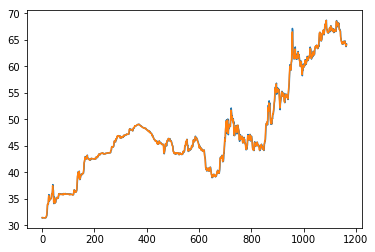

In [55]:
plt.plot(predictions) 
plt.plot(history[train_size:])

In [56]:
mse = mean_squared_error(test_data, predictions)
rmse = sqrt(mse)
print('MSE:%.3f' % mse)
print('RMSE: %.3f' % rmse)

MSE:0.141
RMSE: 0.376
